# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler, AdamW
from datasets import load_metric
from torchsummary import summary
from sklearn import metrics as skmetrics

import numpy as np
from skimage import io
from PIL import Image
import librosa

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm.auto import tqdm
import random

seed_number = 69
# torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seizure_type = "general"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Dataset


In [3]:
class Dataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [4]:
train_x = np.load(f"{path}/train_{seizure_type}_x.npy")
train_y = np.load(f"{path}/train_{seizure_type}_y.npy")

validation_x = np.load(f"{path}/validation_{seizure_type}_x.npy")
validation_y = np.load(f"{path}/validation_{seizure_type}_y.npy")

test_x = np.load(f"{path}/test_{seizure_type}_x.npy")
test_y = np.load(f"{path}/test_{seizure_type}_y.npy")

In [5]:
# Add channel dimension to all sets
print(train_x.shape, validation_x.shape, test_x.shape)
train_x = np.expand_dims(train_x, axis=1)
validation_x = np.expand_dims(validation_x, axis=1)
test_x = np.expand_dims(test_x, axis=1)
print(train_x.shape, validation_x.shape, test_x.shape)

(5744, 40, 26) (1070, 40, 26) (534, 40, 26)
(5744, 1, 40, 26) (1070, 1, 40, 26) (534, 1, 40, 26)


In [6]:
train_dataset = Dataset(
    (train_x, train_y), transform=torch.tensor, target_transform=torch.tensor
)
validation_dataset = Dataset(
    (validation_x, validation_y), transform=torch.tensor, target_transform=torch.tensor
)
test_dataset = Dataset(
    (test_x, test_y), transform=torch.tensor, target_transform=torch.tensor
)

# Model

Mobilenet


In [7]:
# # import mobilenet v3 small
# from torchvision.models import mobilenet_v3_small

# model = mobilenet_v3_small()
# # model.classifier[3] = nn.Linear(1024, 2)
# # model = model.to(device)
# model

In [8]:
from SZModel import SZModel, SZModel_Softmax

In [9]:
model = SZModel()
model = model.to(device)
# model
summary(model, (1, 40, 26), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 20, 13]             144
       BatchNorm2d-2            [1, 16, 20, 13]              32
         Hardswish-3            [1, 16, 20, 13]               0
            Conv2d-4             [1, 16, 10, 7]           2,304
              ReLU-5             [1, 16, 10, 7]               0
            Conv2d-6             [1, 16, 10, 7]             144
       BatchNorm2d-7             [1, 16, 10, 7]              32
              ReLU-8             [1, 16, 10, 7]               0
            Conv2d-9             [1, 16, 10, 7]             256
      BatchNorm2d-10             [1, 16, 10, 7]              32
           Conv2d-11              [1, 16, 5, 4]           2,304
      BatchNorm2d-12              [1, 16, 5, 4]              32
        Hardswish-13              [1, 16, 5, 4]               0
           Conv2d-14              [1, 1

# Train


## Training Loop


In [10]:
batch_size = 512
b_shuffle = True

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=b_shuffle
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=b_shuffle
)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=b_shuffle)

### Print Inputs


In [11]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Train // Background: {bk} // {seizure_type} Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(validation_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Validation // Background: {bk} // {seizure_type} Seizure: {sz}")

Train // Background: 2872 // general Seizure: 2872
Validation // Background: 830 // general Seizure: 240


In [12]:
# # Example of sample

# for i, v in enumerate(train_dataloader):
#     print(v[0][0].shape, v[1].shape)
#     print(v[1][0])
#     plt.imshow(np.transpose(v[0][0], (1, 2, 0)))
#     break

### 70/20/10 Training


In [13]:
num_epochs = 200
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [14]:
b_loss = True
print(f"Training {seizure_type} for {num_epochs} epochs")
print(" ")

loss_track = []
valid_loss_track = []
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1} / {num_epochs}")

    model.train()
    loss_batch = 0.0
    batch_counter = 0
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        loss_batch += loss
        batch_counter += 1

    if b_loss:
        print(f"Train Loss: {(loss_batch / batch_counter)}")
    loss_track.append((loss_batch / batch_counter))

    model.eval()
    valid_loss_batch = 0.0
    eval_batch_counter = 0
    with torch.no_grad():
        for vbatch in validation_dataloader:
            vinputs, vlabels = vbatch
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vlabels = vlabels.to(torch.int64)

            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            valid_loss_batch += vloss
            eval_batch_counter += 1

    if b_loss:
        print(f"Validation Loss: {(valid_loss_batch / eval_batch_counter)}")
    valid_loss_track.append((valid_loss_batch / eval_batch_counter))
    torch.cuda.empty_cache()
    print("─" * 50)
print("Training Complete")

Training general for 200 epochs
 
Epoch: 1 / 200
Train Loss: 0.6628035306930542
Validation Loss: 0.6694494485855103
──────────────────────────────────────────────────
Epoch: 2 / 200
Train Loss: 0.6521562337875366
Validation Loss: 0.6531723737716675
──────────────────────────────────────────────────
Epoch: 3 / 200
Train Loss: 0.6417722702026367
Validation Loss: 0.6476141810417175
──────────────────────────────────────────────────
Epoch: 4 / 200
Train Loss: 0.6318867206573486
Validation Loss: 0.6413280367851257
──────────────────────────────────────────────────
Epoch: 5 / 200
Train Loss: 0.6223011016845703
Validation Loss: 0.6295850276947021
──────────────────────────────────────────────────
Epoch: 6 / 200
Train Loss: 0.6112132668495178
Validation Loss: 0.6182236671447754
──────────────────────────────────────────────────
Epoch: 7 / 200
Train Loss: 0.600440502166748
Validation Loss: 0.6079672574996948
──────────────────────────────────────────────────
Epoch: 8 / 200
Train Loss: 0.5875767

tensor(0.2633)


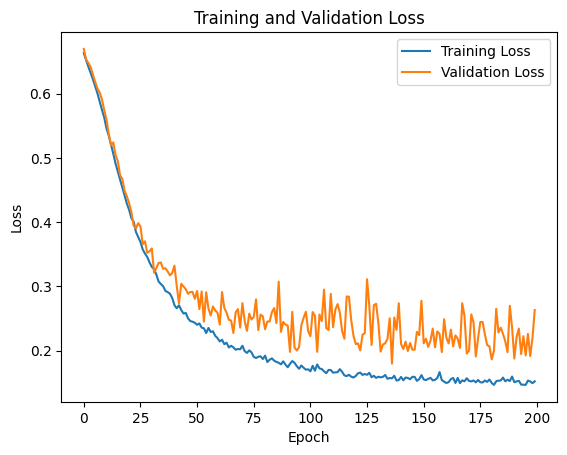

In [15]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].to("cpu").detach())

b = []
for i in range(len(valid_loss_track)):
    b.append(valid_loss_track[i].to("cpu").detach())
print(b[-1])

plt.plot(range(len(a)), a, label="Training Loss")
plt.plot(range(len(b)), b, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"results/pytorch_inference/default/{seizure_type}/{seizure_type}_loss.png")
plt.show()

In [16]:
tp, fp, tn, fn = 0, 0, 0, 0

actual_test = []
predicted_test = []
pre_softmax_predicted_test = []

for batch in test_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.to(torch.int64)

    model.eval()
    with torch.no_grad():
        # print(inputs.shape)
        output = model(inputs)

    for i in output:
        pre_softmax_predicted_test.append(i)

    output = nn.functional.softmax(output, dim=1)

    for i in labels:
        actual_test.append(i)
    for i in output:
        predicted_test.append(i)

    output = output[0]

    if labels[0] == torch.tensor([1]).to(device):
        if torch.round(output[1], decimals=4) > torch.round(output[0], decimals=4):
            tp += 1
        else:
            fn += 1
    elif labels[0] == torch.tensor([0]).to(device):
        if torch.round(output[0], decimals=4) > torch.round(output[1], decimals=4):
            tn += 1
        else:
            fp += 1

In [17]:
from imblearn import metrics as imetrics

In [18]:
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)
precision = (tp) / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:")
print(
    f"""
      ////                 Is Seizure, Is Not Seizure
      Is Seizure           {tp} ({round(tp/(tp + tn + fp + fn),2)}%)   {fp}({round(fp/(tp + tn + fp + fn),2)}%)
      Is Not Seizure       {fn} ({round(fn/(tp + tn + fp + fn),2)}%)   {tn}({round(tn/(tp + tn + fp + fn),2)}%)

      Sensitivity: {sensitivity}
      Specificity: {specificity}
      Precision: {precision}
      Accuracy: {accuracy}
      """
)
print(tp + tn + fp + fn)

Confusion Matrix:

      ////                 Is Seizure, Is Not Seizure
      Is Seizure           98 (0.18%)   13(0.02%)
      Is Not Seizure       38 (0.07%)   385(0.72%)

      Sensitivity: 0.7205882352941176
      Specificity: 0.9673366834170855
      Precision: 0.8828828828828829
      Accuracy: 0.9044943820224719
      
534


In [19]:
y_true = []
y_score = []
y_pred = []

for i in actual_test:
    y_true.append(i.to("cpu").item())
for i in predicted_test:
    y_score.append(i[1].to("cpu").item())
for i in predicted_test:
    if i[1] > i[0]:
        y_pred.append(1)
    else:
        y_pred.append(0)

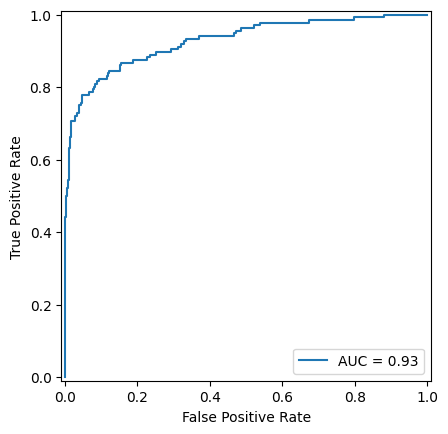

In [20]:
fpr, tpr, thresholds = skmetrics.roc_curve(y_true=y_true, y_score=y_score)
roc_auc = skmetrics.auc(fpr, tpr)
gmean = imetrics.geometric_mean_score(y_true, y_pred)

dis = skmetrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

dis.plot()
dis.figure_.savefig(
    f"results/pytorch_inference/default/{seizure_type}/{seizure_type}_roc.png"
)

In [21]:
y_pred = []
for i in y_score:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
confusion_matrix = skmetrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
print(confusion_matrix)

[[385  13]
 [ 38  98]]


In [22]:
torch.save(model.state_dict(), f"model/pytorch_models/{seizure_type}_model.pt")

In [23]:
row = [
    [
        seizure_type,
        round(accuracy * 100, 3),
        round(sensitivity * 100, 3),
        round(specificity * 100, 3),
        round(precision * 100, 3),
        round(roc_auc * 100, 3),
        round(gmean * 100, 3),
        f"{tp} / {fn} / {tn} / {fp}",
    ]
]


df = pd.DataFrame(
    row,
    columns=[
        "seizure_type",
        "accuracy",
        "sensitivity",
        "specificity",
        "precision",
        "roc_auc",
        "gmean",
        "tp / fn /tn / fp",
    ],
)

In [24]:
df

,seizure_type,accuracy,sensitivity,specificity,precision,roc_auc,gmean,tp / fn /tn / fp
0,general,90.449,72.059,96.734,88.288,92.832,83.49,98 / 38 / 385 / 13


In [25]:
df.to_csv(
    f"results/pytorch_inference/default/{seizure_type}/{seizure_type}_pytorch_results.csv"
)

In [94]:
row = [
    [
        seizure_type,
        learning_rate,
        batch_size,
        num_epochs,
    ]
]


df = pd.DataFrame(
    row,
    columns=[
        "seizure_type",
        "learning rate",
        "batch_size",
        "epochs",
    ],
)

In [95]:
df

,seizure_type,learning rate,batch_size,epochs
0,absence,0.00005,512,200


In [96]:
df.to_csv(
    f"results/pytorch_inference/softmax/{seizure_type}/{seizure_type}_pytorch_hyperparameters.csv"
)